# Predicting board game reviews

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline

# Reading the dataset

board_games = pd.read_csv("board_games.csv")

In [166]:
# Initial exploration
print(board_games.shape)
board_games.head()

(81312, 20)


,id,type,name,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,users_rated,average_rating,bayes_average_rating,total_owners,total_traders,total_wanters,total_wishers,total_comments,total_weights,average_weight
0,12333,boardgame,Twilight Struggle,2005,2,2,180,180,180,13,20113,8.33774,8.22186,26647,372,1219,5865,5347,2562,3.4785
1,120677,boardgame,Terra Mystica,2012,2,5,150,60,150,12,14383,8.28798,8.14232,16519,132,1586,6277,2526,1423,3.8939
2,102794,boardgame,Caverna: The Cave Farmers,2013,1,7,210,30,210,12,9262,8.28994,8.06886,12230,99,1476,5600,1700,777,3.7761
3,25613,boardgame,Through the Ages: A Story of Civilization,2006,2,4,240,240,240,12,13294,8.20407,8.05804,14343,362,1084,5075,3378,1642,4.1590
4,3076,boardgame,Puerto Rico,2002,2,5,150,90,150,12,39883,8.14261,8.04524,44362,795,861,5414,9173,5213,3.2943


## Data Cleaning

In [167]:
board_games.dropna(axis = 1)
board_games = board_games[board_games["users_rated"] != 0]

## Data exploration

1.5785522573378215

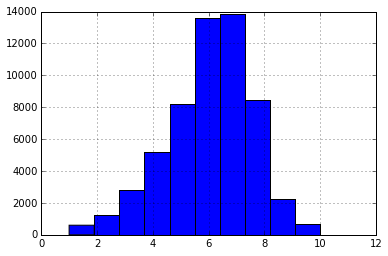

In [168]:
# Checking the distribution using histogram.

board_games["average_rating"].hist()

# Standard deviation.

board_games["average_rating"].std()


In [169]:
# Calculating mean
board_games["average_rating"].mean()

6.0159108485561728

The distribution appears to more of normal distribution so Sum of square error is a much better choice for an error metric

## Plotting clusters

In [170]:
numeric_data = board_games._get_numeric_data()
clean_data = numeric_data.drop("id", axis = 1)
clean_data = clean_data.dropna()
clean_data.head()
board_games_numeric = clean_data
km = KMeans(n_clusters = 5, random_state = 1)
km.fit(board_games_numeric)
labels = km.labels_
game_mean = board_games_numeric.apply(axis = 1, func = np.mean)
game_std = board_games_numeric.apply(axis = 1, func = np.std)

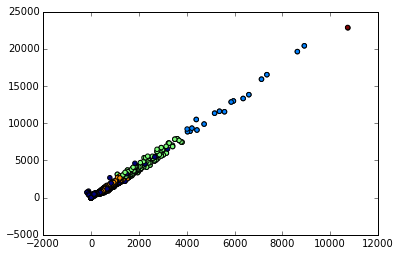

In [171]:
plt.scatter(x = game_mean, y = game_std, c = labels)
plt.show()

## Finding correlations

In [172]:
correlations = board_games_numeric.corr(method = "pearson")

In [173]:
correlations["average_rating"]

yearpublished           0.108396
minplayers             -0.032841
maxplayers             -0.008338
playingtime             0.048987
minplaytime             0.043978
maxplaytime             0.048987
minage                  0.209900
users_rated             0.112570
average_rating          1.000000
bayes_average_rating    0.231579
total_owners            0.137485
total_traders           0.119472
total_wanters           0.196567
total_wishers           0.171377
total_comments          0.123723
total_weights           0.109697
average_weight          0.351053
Name: average_rating, dtype: float64

That's intereseting average weight is most positively correlated to the average rating. There is no clear thoughts on bayes_average_rating and appears to same form of ratings. If it is than this would cause the model to overfit.

### Droping the table columns that are irrelevant.

In [174]:
fe_board_games = board_games_numeric.drop(["minplayers","playingtime","minplaytime","maxplaytime","bayes_average_rating"], axis = 1)

In [175]:
fe_board_games.shape
fe_board_games.columns

Index(['yearpublished', 'maxplayers', 'minage', 'users_rated', 'average_rating', 'total_owners', 'total_traders', 'total_wanters', 'total_wishers', 'total_comments', 'total_weights', 'average_weight'], dtype='object')

## Model creation

In [176]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
cols = list(fe_board_games.columns)
cols.remove("average_rating")
linear_model.fit(fe_board_games[cols],fe_board_games["average_rating"])
predicted_ratings = linear_model.predict(fe_board_games[cols])

# Error
np.mean((predicted_ratings - fe_board_games["average_rating"]) ** 2)

2.0963933803300936

The mean squared error is very large and hence this is not a good predictor. 

In [177]:
## Using cross validation

shuffler = np.random.permutation(fe_board_games.index)
shuffler_board_games = fe_board_games.loc[shuffler]
split_percent = int(0.8 * shuffler_board_games.shape[0])

train = shuffler_board_games.iloc[0:split_percent]
test = shuffler_board_games.iloc[split_percent: len(shuffler_board_games)]

In [178]:
cv_linear_model = LinearRegression()
cv_linear_model.fit(train[cols], train["average_rating"])
predicted_rating = cv_linear_model.predict(test[cols])

In [179]:
np.mean((predicted_rating - test["average_rating"]) ** 2)

2.1534524770861498

Even after cross validation the squared error is very large and hence this confirms that the predictions are not perfect and hence we need to have good predictors.